In [67]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("presuicidal_signals_dataset_twitter.csv",delimiter="|")
non_suicidal = data.loc[data['label'] == 5].head(1000)[['text', 'label']].rename(columns={'label': 'class'}).replace(5, 0)
non_suicidal

,text,class
0,встаём завтра в 8 утра и делаем все дела,0
1,меня позвали на суши. и боюсь и хочу. согласил...,0
2,валя <emoji>Skull</emoji>,0
3,то есть вы не пишете на столько бессмысленную ...,0
4,Не знаю почему никто не сделал или я не нашëл ...,0
...,...,...
1777,Могу надо досье Айдан?,0
1778,"время 14:35 а уже темно блять становится, че з...",0
1779,Настроение такое разъебывающее прям вот аааааа,0
1781,"Егор: - Ты пойдëшь? \nЯ: - Не, вы ж там калибр...",0


In [68]:
data = pd.read_csv("own_shit.csv")
suicidal = data[['text', 'class']]
suicidal

,text,class
0,Мне сложно находиться на едине с самим собой н...,1
1,"я умру в полном одиночестве, ведь в моём состо...",1
2,"живу тягой безжалостно себя убить много лет, н...",1
3,"Всем привет, думаю что могу скоро откинуться я...",1
4,"Я хочу умереть. Всё плохо, в отношениях попада...",1
...,...,...
995,Мне надоело жить,1
996,"А у меня возраст Христа,и на этот новый год я ...",1
997,"Сам себя обманываю, придумываю причины остават...",1
998,"Каждый день я засыпаю ,надеясь что завтра не п...",1


In [69]:
data = non_suicidal.append(suicidal)
data

/var/folders/nd/rxp2phv12xl4m1wk92ksqgxr0000gn/T/ipykernel_3286/1650890766.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = non_suicidal.append(suicidal)


,text,class
0,встаём завтра в 8 утра и делаем все дела,0
1,меня позвали на суши. и боюсь и хочу. согласил...,0
2,валя <emoji>Skull</emoji>,0
3,то есть вы не пишете на столько бессмысленную ...,0
4,Не знаю почему никто не сделал или я не нашëл ...,0
...,...,...
995,Мне надоело жить,1
996,"А у меня возраст Христа,и на этот новый год я ...",1
997,"Сам себя обманываю, придумываю причины остават...",1
998,"Каждый день я засыпаю ,надеясь что завтра не п...",1


In [70]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          plot_place=[0, 0, 0]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.subplot(*plot_place)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [71]:
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def deleteShitEmojis(string):
    newStr = ""
    i = 0
    try:
        len(string)
    except:
        return newStr
    while (i < len(string)):
        if (string[i] == "<"):
            while (i < len(string) and string[i] != ">"):
                i += 1
            i += 1
            # while (i < len(string) and string[i] != "<"):
                # if (string[i] != " "):
                    # newStr += string[i]
                # else:
                    # newStr += "_"
                # i += 1
            # newStr += " "
            # i += 1
            while (i < len(string) and string[i] != ">"):
                i += 1
            i += 1
        else:
            newStr += string[i]
        i += 1
    
    return newStr

In [72]:
data['text'] = data['text'].apply(lambda string: " ".join(deleteShitEmojis(remove_emoji(string)).split("\n")))
data.to_csv("trash_wip.csv")

In [73]:
data = data.sample(frac=1)
data

,text,class
642,Мне очень нужна помощь...наверное... Читала ка...,1
1301,я ночью нарисовал рисуночек °^°,0
1310,"Паймон, но не доделанная бляха я вообще в этом...",0
1273,из 16 пунктов внутренней гомофобии у меня 8. б...,0
1624,"ищу человека, который будет заваривать мне чай...",0
...,...,...
434,Нахожу успокоение в моём маленьком мазохизме. ...,1
141,Видимо он воскресень...,0
162,"Ахахахах, да кому я нужен блять, ничтожество е...",1
571,"Я думаю, мы просто не прошли естественный отбо...",1


In [74]:
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

an = MorphAnalyzer(lang='ru')
stops = stopwords.words('russian')

def getClearSentences(sentences):
    return " ".join(str(s) + "" for s in (an.normal_forms(y)[0] for y in filter(lambda x: x not in stops, nltk.word_tokenize(str(sentences)))))

data['text'] = data['text'].apply(lambda x: getClearSentences(x))
corpus = data['text']
corpus

642     я очень нужный помощь ... наверное ... читать ...
1301                       ночью нарисовать рисуночек °^°
1310    паймона , доделать бляха вообще год заканчиват...
1273    16 пункт внутренний гомофобия 8. блядь . добры...
1624    искать человек , который заваривать чай , пока...
                              ...                        
434     находить успокоение мой маленький мазохизм . н...
141                                 видимо воскресень ...
162       ахахахи , кто нужный блядь , ничтожество ебучий
571     я думать , просто пройти естественный отбор . ...
407             ты скучно ? простить , клоун , развлекать
Name: text, Length: 2500, dtype: object

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorized_data = vectorizer.fit_transform(corpus)
vectorized_data

<2500x9859 sparse matrix of type '<class 'numpy.int64'>'
	with 48430 stored elements in Compressed Sparse Row format>

In [76]:
classes_data = data['class'].apply(lambda x: int(x))

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

def confusionMatrices(estimator, classes = []):
    splits = 3
    kf = KFold(n_splits=splits)
    n = 1
    plt.figure(figsize=(20, 10))
    for train, test in kf.split(vectorized_data):
        estimator.fit(vectorized_data[train], classes_data.iloc[train].values.ravel())
        predicted = estimator.predict(vectorized_data[test])

        matrix = confusion_matrix(classes_data.iloc[test], predicted)
        plot_confusion_matrix(matrix, classes, plot_place=[splits, 1, n])
        n += 1

def crossScores(estimator):
    crossScoreF = cross_val_score(estimator, scoring='f1_micro', X=vectorized_data, y=classes_data.tolist(), cv=3)

    plt.plot(crossScoreF)
    plt.title("f1 micro")


from sklearn.model_selection import GridSearchCV

def gridSearch(estimator, paramGrid):

    xTrain, xTest, yTrain, yTest = train_test_split(vectorized_data, classes_data, test_size=0.2)

    searchCV = GridSearchCV(estimator, param_grid=paramGrid)
    searchCV.fit(xTrain, yTrain)
    print(searchCV.best_params_)
    searchCV.cv_results_

# Градиентный бустинг

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
gridSearch(estimator, paramGrid={'learning_rate': [0.1, 0.5, 1, 2], 'min_samples_split': [2, 3, 6], 'n_estimators': [20, 40, 60]})

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packages

{'learning_rate': 0.5, 'min_samples_split': 3, 'n_estimators': 60}


Confusion matrix, without normalization
[[469  26]
 [ 78 261]]
Confusion matrix, without normalization
[[482  20]
 [ 90 241]]
Confusion matrix, without normalization
[[484  19]
 [102 228]]


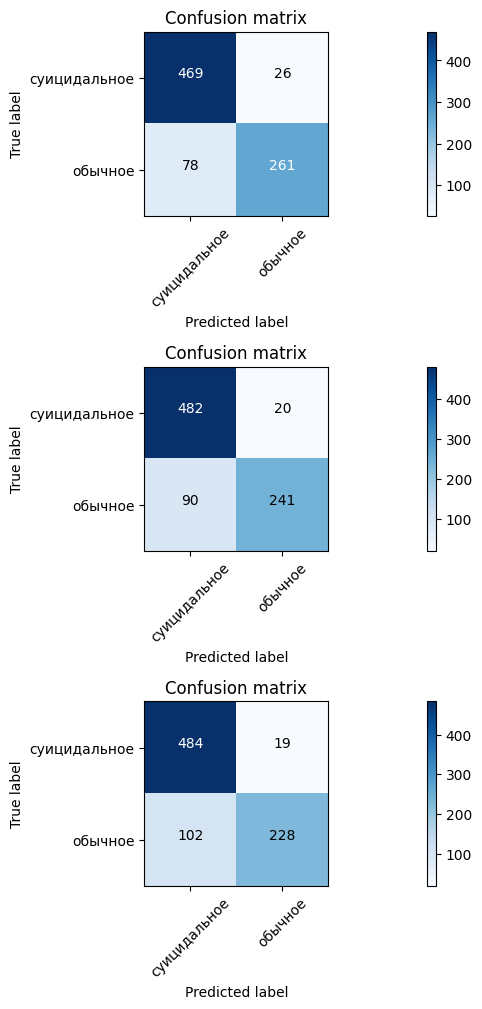

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier(learning_rate=0.4, min_samples_split=3, n_estimators=60)
confusionMatrices(estimator=estimator, classes=["суицидальное", "обычное"])

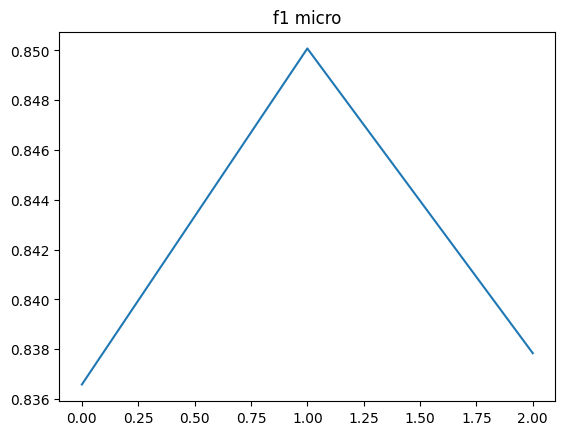

In [48]:
crossScores(estimator)

In [65]:
estimator.predict(vectorizer.transform([getClearSentences("Впизду все это, заебало нахуй. Зачем я здесь? Что мне уготовлено? проще вздернуться")]))

array([0])

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
gridSearch(estimator, paramGrid={'n_jobs': [-1],'n_estimators': [1, 10, 100, 500], 'max_depth':[None, 10, 100], 'class_weight': [None, 'balanced', 'balanced_subsample']})

{'class_weight': 'balanced_subsample', 'max_depth': 100, 'n_estimators': 500, 'n_jobs': -1}


Confusion matrix, without normalization
[[181  19]
 [ 35 165]]
Confusion matrix, without normalization
[[169  27]
 [ 43 161]]
Confusion matrix, without normalization
[[173  31]
 [ 35 161]]


<Figure size 2000x1000 with 0 Axes>

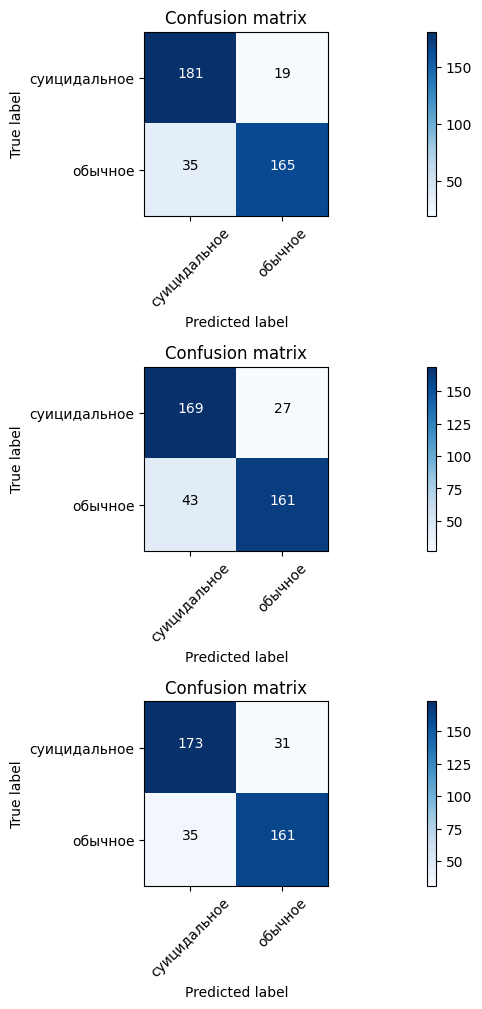

In [20]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1, n_estimators=500, max_depth=100)
plt.figure(figsize=(20, 10))
confusionMatrices(estimator, ["суицидальное", "обычное"])

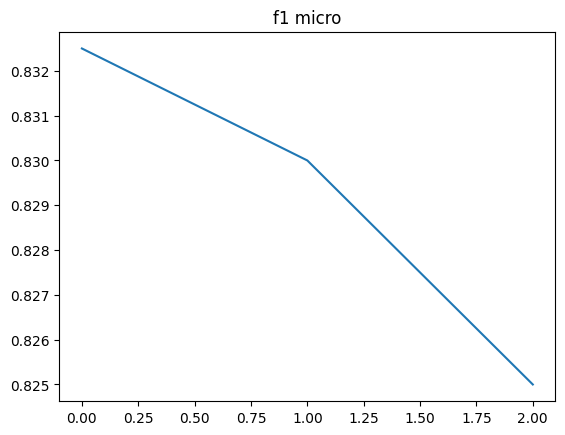

In [21]:
estimator = RandomForestClassifier(n_jobs=-1, n_estimators=500)
crossScores(estimator)

# SVC

In [23]:
from sklearn.svm import SVC

estimator = SVC()
gridSearch(estimator, paramGrid={'C': [1.0, 2.0, 10.0, 100.0], 'degree': [3, 4, 6, 7], 'kernel': ['linear', 'poly', 'rbf']})

{'C': 1.0, 'degree': 3, 'kernel': 'linear'}


Confusion matrix, without normalization
[[180  20]
 [ 36 164]]
Confusion matrix, without normalization
[[173  23]
 [ 34 170]]
Confusion matrix, without normalization
[[183  21]
 [ 29 167]]


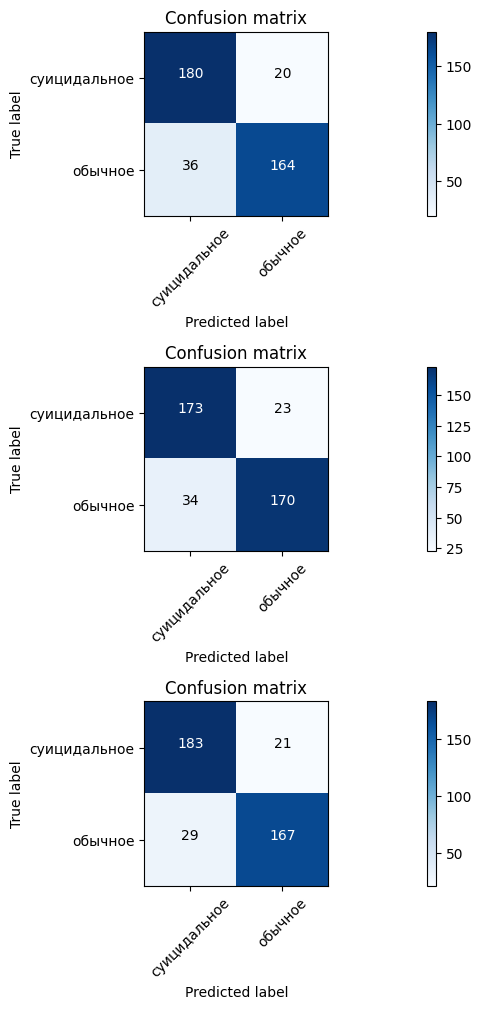

In [24]:
estimator = SVC(C=1.0, degree=3, kernel='linear')
confusionMatrices(estimator, ["суицидальное", "обычное"])

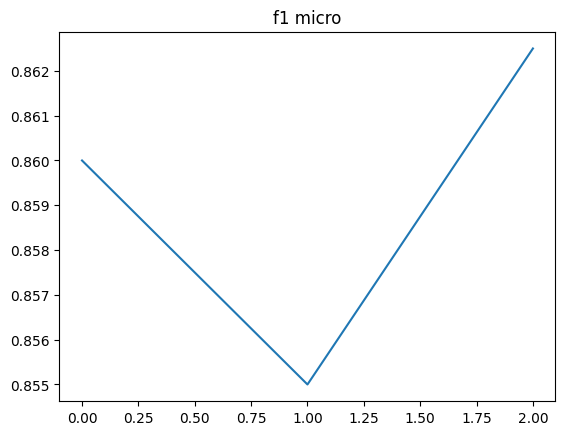

In [25]:
crossScores(estimator)